# Load Data

In [1]:
import seaborn as sns

In [2]:
import pandas as pd

df = pd.read_csv("../data/all.csv")
print ("Columns of df: ",  list(enumerate(df.columns)), "\n")

print ("Shape of df: ", df.shape, "\n")

print ("Number of songs having lyrics: ", df['lyrics'].notnull().sum(), "\n")



Columns of df:  [(0, 'Age'), (1, 'Album_Name'), (2, 'Artist'), (3, 'Year'), (4, 'Description'), (5, 'Age Group'), (6, 'Album_ID'), (7, 'Album_Name_Spotify'), (8, 'Artists_Spotify'), (9, 'Track_ID'), (10, 'ISRC'), (11, 'Track_Name'), (12, 'Artists'), (13, 'popularity'), (14, 'preview_url'), (15, 'image_url'), (16, 'danceability'), (17, 'energy'), (18, 'key'), (19, 'loudness'), (20, 'mode'), (21, 'speechiness'), (22, 'acousticness'), (23, 'instrumentalness'), (24, 'liveness'), (25, 'valence'), (26, 'tempo'), (27, 'type'), (28, 'uri'), (29, 'track_href'), (30, 'analysis_url'), (31, 'duration_ms'), (32, 'time_signature'), (33, 'lyrics')] 

Shape of df:  (19560, 34) 

Number of songs having lyrics:  14270 



In [3]:
df['lyrics'][1023]

"Baby dear, blessed be your shining light\r\nBaby dear, blessed be your morning smile\r\nBaby dear, blessed be your gleaming eyes\r\nBlessed be the precious child, our beloved baby dear\r\n\r\nBaby dear, we will love with all our might\r\nBaby dear, we will comfort you at night\r\nBaby dear, with all the love we've got\r\n...\r\n\r\n******* This Lyrics is NOT for Commercial use *******\r\n(1409621371225)"

In [4]:
#df =  df[df['Age']<6]
df = df.dropna(subset=['lyrics'])
df = df.reset_index(drop=True)

import re

def remove_disclaimer(string):
    s = re.sub(r'(\*)+ This Lyrics is NOT for Commercial use .*\r\n\([0-9]*\)',"", string)
    return s

df['lyrics'] = df['lyrics'].apply(remove_disclaimer)

In [5]:
df['lyrics'][5]

"Bing bang bong, a ring rang rong\r\nThat's a pirate song\r\nI love to sing (he loves to sing)\r\nI'll sing anything (he'll sing anything)\r\nCaptain Feathersword sings\r\n\r\nOoh, I love to eat (he loves to eat)\r\nI'll eat anything (he'll eat anything)\r\nCaptain Feathersword eats\r\n...\r\n\r\n"

# Text Processing

In [6]:
import spacy
nlp = spacy.load("en", disable=['parser','ner','tagger', 'textcat'])

In [27]:
import re

def my_lemmatizer(doc):
    doc_cleaned = ' '.join(re.findall(r'\b\w[\w\']+\b', doc))
    return [ w.lemma_.lower() for w in nlp(doc_cleaned) 
                      if w.lemma_ not in ['_', '.', '-PRON-','oh'] ]

stopwords = spacy.lang.en.stop_words.STOP_WORDS

stopwords = set(my_lemmatizer(' '.join(list(stopwords))))

In [28]:
df['lyrics']

0        In old Transylvania when I was a lad\r\nOur ca...
1        Saw a monster in the mirror when I woke up tod...
2        The Big Red Car rolls along the street\r\nAnd ...
3        Every night under the sea, a friendly octopus,...
4        Having fun at the beach\r\nHaving fun at the b...
                               ...                        
14265    Just saw an alien saucer approaching from the ...
14266    Just saw an alien saucer approaching from the ...
14267    Just saw an alien saucer approaching from the ...
14268    Just saw an alien saucer approaching from the ...
14269    Rack rack city, bitch\r\nRack rack rack city, ...
Name: lyrics, Length: 14270, dtype: object

In [29]:
s = df['lyrics'][0]

In [10]:
import re
re.sub?

In [11]:

re.sub(r'(\*){7} This Lyrics is NOT for Commercial use .*\r\n\([0-9]*\)',"", s)

"In old Transylvania when I was a lad\r\nOur castle was poor but we never were sad\r\nWe learned to be happy\r\nWe'd dance round the hall\r\nAnd learning to count was the key to it all\r\nBy counting each count I knew just where to start\r\nAnd one special step has stayed close to my heart\r\n\r\nOne two three, spread out the cape\r\nOne two three, twirl round the floor\r\nOne two three, left foot you swing\r\nOne two three, then start to sing\r\nOne two three, loud as you please\r\n...\r\n\r\n"

# Bag-of-Words Model + K-Mean clustering

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
max_features = 1000

cv = CountVectorizer(tokenizer=my_lemmatizer, stop_words=stopwords, 
                     min_df=1, max_df=0.9, max_features=max_features)
counts = cv.fit_transform(df['lyrics'])

tf = TfidfTransformer()
matrix = tf.fit_transform(counts)

In [31]:
import random   
random.sample(list(cv.get_feature_names_out()), 10)    #random select 10 words from CountVectorizer

['pimp',
 'moment',
 'bone',
 'okay',
 'shirt',
 'pressure',
 'sky',
 'callin',
 'stack',
 'sunshine']

In [32]:
from sklearn.cluster import KMeans
number_of_clusters = 5

kmc_5 = KMeans(n_clusters=number_of_clusters, n_init=3, random_state=117)  # random_state for consistency
kmc_5.fit(matrix)
kmc_5.cluster_centers_
import numpy as np

number_of_top_words = 10

cluster_words = np.argsort(kmc_5.cluster_centers_, axis=1)
terms = cv.get_feature_names_out()

top_words = set()

for i in range(number_of_clusters):
    print('Cluster {}: '.format(i))
    print(' '.join([terms[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([terms[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words = sorted(list(top_words))

Cluster 0: 
wanna want cause way think let like feel time know 

Cluster 1: 
que hey think girl love find yes de like la 

Cluster 2: 
love wanna want hey ooh like know girl baby yes 

Cluster 3: 
yes cause day want look let man know come like 

Cluster 4: 
come let heart need feel want baby like know love 



In [33]:
word_df = pd.DataFrame(counts.toarray(), columns=terms)[top_words]
word_df['Cluster'] = kmc_5.labels_.tolist()
word_df.sample(3)

,baby,cause,come,day,de,feel,find,girl,heart,hey,...,need,ooh,que,think,time,wanna,want,way,yes,Cluster
1717,3,0,0,0,0,0,0,0,1,2,...,1,0,0,3,0,2,1,1,0,4
3336,1,1,0,1,0,0,0,0,0,9,...,0,0,0,0,0,0,0,1,1,2
9490,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,2


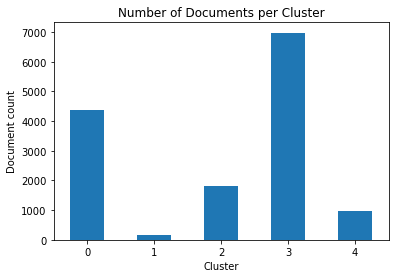

In [34]:
word_df.groupby('Cluster').count()[top_words[0]].\
    plot.bar(rot=0).\
    set(ylabel='Document count',
    title='Number of Documents per Cluster');

# Latent Dirichlet allocation (LDA)

In [35]:
import gensim

import re
def process_words(texts, stop_words=set()):
    result = []
    for t in texts:
        t = ' '.join(re.findall(r'\b\w[\w\']+\b', t))
        doc = nlp(t)
        result.append([token.lemma_.lower() for token in doc if token.lemma_ not in stop_words])
    return result

processed_text = process_words(df['lyrics'], stop_words=stopwords.union(['-PRON-', 'oh']))

In [36]:
dictionary = gensim.corpora.Dictionary(processed_text)
print('Number of unique tokens: {}'.format(len(dictionary)))
corpus = [dictionary.doc2bow(t) for t in processed_text]
num_topics = 5

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            random_state=117, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

Number of unique tokens: 25548


In [19]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.026*"la" + 0.014*"black" + 0.012*"like" + 0.010*"she" + 0.010*"new" + '
  '0.009*"bitch" + 0.008*"night" + 0.008*"party" + 0.008*"hoe" + 0.007*"ma"'),
 (1,
  '0.029*"and" + 0.020*"you" + 0.018*"know" + 0.015*"the" + 0.014*"come" + '
  '0.014*"time" + 0.012*"let" + 0.012*"but" + 0.010*"fall" + 0.009*"away"'),
 (2,
  '0.114*"oh" + 0.059*"love" + 0.048*"know" + 0.042*"yes" + 0.038*"baby" + '
  '0.027*"you" + 0.024*"want" + 0.021*"ooh" + 0.020*"and" + 0.020*"girl"'),
 (3,
  '0.033*"and" + 0.025*"like" + 0.017*"but" + 0.015*"feel" + 0.013*"know" + '
  '0.011*"need" + 0.010*"man" + 0.010*"want" + 0.009*"what" + 0.009*"way"'),
 (4,
  '0.035*"like" + 0.018*"come" + 0.017*"girl" + 0.017*"na" + 0.015*"shit" + '
  '0.015*"let" + 0.014*"you" + 0.012*"nigga" + 0.012*"hey" + 0.012*"wanna"')]


In [20]:
lda_model.get_document_topics(corpus[0])

[(0, 0.29254863), (1, 0.46760994), (3, 0.23324442)]

In [21]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [22]:
main_topic_df = get_main_topic_df(lda_model, corpus, processed_text)

main_topic_df.sample(10)

,Dominant_topic,Percent,Processed_text,Keywords
9112,4,0.938,"[na, na, na, na, na, na, na, na, na, na, na, n...",come girl hey let like na nigga shit wanna you
7379,2,0.811,"[most, people, think, huh, why, know, afraid, ...",and baby girl know love oh ooh want yes you
4463,2,0.821,"[wanna, wait, vain, love, wanna, wait, vain, l...",and baby girl know love oh ooh want yes you
8278,1,0.547,"[bad, disease, beg, hand, knee, so, emergency,...",and away but come fall know let the time you
3348,4,0.901,"[chorus, bounce, wit, bounce, wit, wanna, know...",come girl hey let like na nigga shit wanna you
10507,3,0.708,"[well, care]",and but feel know like man need want way what
10506,2,0.430,"[look, stare, deep, eye, touch, time, when, le...",and baby girl know love oh ooh want yes you
9343,4,0.776,"[yeah, yes, yes, rock, like, no, swift, like, ...",come girl hey let like na nigga shit wanna you
1502,1,0.949,"[dream, white, christmas, just, like, know, wh...",and away but come fall know let the time you
5582,1,0.632,"[found, way, highway, wanna, tell, state, smok...",and away but come fall know let the time you


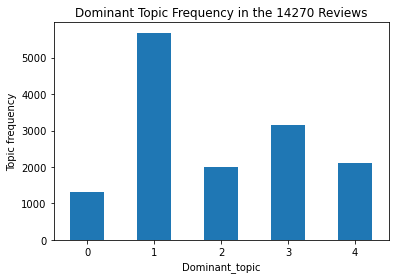

In [23]:
grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Processed_text'].\
    plot.bar(rot=0).\
    set(title='Dominant Topic Frequency in the {} Reviews'.format(len(df)),
        ylabel='Topic frequency'); 

In [24]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([ representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(1) ])
    
representatives

,Dominant_topic,Percent,Processed_text,Keywords
10818,0,0.994,"[sean, paul, pa, toa, en, la, calle, te, quier...",bitch black hoe la like ma new night party she
7014,1,0.985,"[when, day, cold, and, card, fold, and, saint,...",and away but come fall know let the time you
8801,2,0.991,"[late, glass, sit, for, night, ignoring, every...",and baby girl know love oh ooh want yes you
3906,3,0.985,"[another, blinger, slick, trigger, finger, her...",and but feel know like man need want way what
11086,4,0.993,"[wanna, rock, right, want, wanna, rock, right,...",come girl hey let like na nigga shit wanna you


In [25]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive



def f(idx):
    print('Document: {}  Dominant topic: {}\n'.format(representatives.index[idx], 
                                       representatives.loc[representatives.index[idx]]['Dominant_topic']))
    print(df['lyrics'][representatives.index[idx]])

    
interactive(f, idx = widgets.Dropdown(options=[0,1,2,3,4], value=0, description='topic id'))

interactive(children=(Dropdown(description='topic id', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_clas…